### Deep FBA Trader model creation

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer
from tensorflow.keras.utils import Sequence
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os

Combining training data into one csv file

In [ ]:
root_folder_path = 'C:/Users/camer/Documents/Masters Thesis/Data/Training data/'
specific_folder = '1 sec batch full trading day'
folder_path = root_folder_path + specific_folder

data_sets = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        data_set = pd.read_csv(file_path)
        data_sets.append(data_set)

large_csv = pd.concat(data_sets, ignore_index=True)
large_csv.to_csv(f'{folder_path}/all_data.csv', index=False)
training_data = large_csv
training_data

Fitting the scaler for normalisation

In [144]:
folder_path = 'C:/Users/camer/Documents/Masters Thesis/Data/Training data/1secbatch_quotelogs'

training_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]


In [14]:
input_scaler = StandardScaler()
output_scaler = StandardScaler()

for file in training_files:
    for chunk in pd.read_csv(file, chunksize=32768):
        X = chunk.drop(columns=['time_of_trade', 'final_trade_price']).values
        y = chunk[['final_trade_price']].values
        input_scaler.partial_fit(X)
        output_scaler.partial_fit(y)
        

input_scaler_filename = 'input_scaler_equil_predictor.joblib'
output_scaler_filename = 'output_scaler_equil_predictor.joblib'
joblib.dump(input_scaler, input_scaler_filename)
joblib.dump(output_scaler, output_scaler_filename)

['output_scaler_equil_predictor_no_prevbatch.joblib']

In [168]:
input_scaler = joblib.load('scalers/input_scaler_equil_predictor_minmax.joblib')
output_scaler = joblib.load('scalers/output_scaler_equil_predictor_minmax.joblib')

Creating data generator class to batch data for training

In [169]:
output_scaler.data_min_

array([1.])

In [46]:
class DataGenerator(Sequence):
    def __init__(self, training_files, batch_size=1024, input_scaler=None, output_scaler=None, shuffle=False):
        self.training_files = training_files
        self.batch_size = batch_size
        self.input_scaler = input_scaler
        self.output_scaler = output_scaler
        self.shuffle = shuffle
        self.current_file_idx = 0
        self.load_next_file()
        
    def load_next_file(self):
        if self.current_file_idx >= len(self.training_files):
            self.current_file_idx = 0
        self.current_file = self.training_files[self.current_file_idx]
        self.data_iterator = pd.read_csv(self.current_file, chunksize=self.batch_size)

    def __len__(self):
        total_rows = sum([pd.read_csv(file, usecols=[0]).shape[0] for file in self.training_files])
        return total_rows // self.batch_size

    def __getitem__(self, index):
        try:
            chunk = next(self.data_iterator)
        except StopIteration:
            self.current_file_idx += 1
            self.load_next_file()
            chunk = next(self.data_iterator)

        X_batch = chunk.drop(columns=['time_of_trade', 'final_trade_price']).values
        y_batch = chunk['final_trade_price'].values

        if self.input_scaler:
            X_batch = self.input_scaler.transform(X_batch)
        if self.output_scaler:
            y_batch = self.output_scaler.transform(y_batch.reshape(-1, 1)).flatten()

        X_batch = X_batch.reshape((-1, 1, X_batch.shape[1]))

        return X_batch.astype(np.float16), y_batch.astype(np.float16)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.training_files)
        self.current_file_idx = 0
        self.load_next_file()

In [47]:
train_files, test_files = train_test_split(training_files, test_size=0.1, random_state=42)

train_generator = DataGenerator(train_files, batch_size=32000, input_scaler=input_scaler, output_scaler=output_scaler, shuffle=False)
test_generator = DataGenerator(test_files, batch_size=32000, input_scaler=input_scaler, output_scaler=output_scaler, shuffle=False)

# test_data_list = []

# for test_file in test_files:
#     test_data_sample = pd.read_csv(test_file)
#     test_data_list.append(test_data_sample)
 
# test_data = pd.concat(test_data_list, ignore_index=True)

# X_test = test_data.drop(columns=['time_of_trade', 'final_trade_price']).values
# y_test = test_data['final_trade_price'].values

# X_test_scaled = scaler.transform(X_test)

# X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


In [158]:
import pandas as pd
from sklearn.metrics import mean_squared_error

file_path = training_files[9]
data = pd.read_csv(file_path)

actual_values = data['quote_price'].values

# actual_values_scaled = output_scaler.transform(actual_values.reshape(-1, 1)).flatten()

# baseline_prediction_scaled = [actual_values_scaled.mean()] * len(actual_values_scaled)

# baseline_mse_scaled = mean_squared_error(actual_values_scaled, baseline_prediction_scaled)
# print(f"Scaled Baseline MSE: {baseline_mse_scaled}")



In [159]:
actual_values

array([  9,  88,  84, ..., 126, 110, 119], dtype=int64)

In [160]:
actual_values = [x for x in actual_values if x <=500]
actual_values

[9,
 88,
 84,
 68,
 78,
 80,
 86,
 90,
 94,
 92,
 83,
 92,
 75,
 89,
 73,
 101,
 87,
 123,
 105,
 91,
 97,
 89,
 92,
 67,
 66,
 76,
 82,
 93,
 80,
 102,
 89,
 100,
 91,
 89,
 70,
 107,
 68,
 72,
 73,
 82,
 88,
 70,
 83,
 108,
 107,
 91,
 79,
 83,
 6,
 64,
 63,
 67,
 77,
 72,
 68,
 90,
 99,
 88,
 84,
 62,
 69,
 62,
 51,
 70,
 78,
 58,
 94,
 87,
 88,
 116,
 92,
 88,
 101,
 111,
 96,
 94,
 88,
 84,
 94,
 75,
 81,
 54,
 109,
 91,
 100,
 94,
 67,
 78,
 17,
 89,
 105,
 81,
 69,
 74,
 80,
 102,
 77,
 90,
 108,
 76,
 126,
 72,
 81,
 71,
 78,
 62,
 106,
 66,
 106,
 74,
 57,
 97,
 89,
 49,
 74,
 86,
 21,
 68,
 81,
 58,
 77,
 71,
 73,
 69,
 67,
 101,
 75,
 80,
 50,
 95,
 94,
 107,
 113,
 99,
 80,
 99,
 60,
 78,
 54,
 72,
 103,
 95,
 84,
 77,
 58,
 83,
 77,
 69,
 87,
 49,
 80,
 86,
 56,
 79,
 112,
 76,
 65,
 88,
 71,
 68,
 119,
 62,
 66,
 46,
 71,
 91,
 101,
 96,
 25,
 80,
 84,
 75,
 72,
 57,
 59,
 92,
 89,
 71,
 85,
 112,
 84,
 82,
 89,
 78,
 104,
 106,
 93,
 80,
 129,
 77,
 68,
 66,
 125,
 95,
 

In [162]:
min(actual_values)

-276

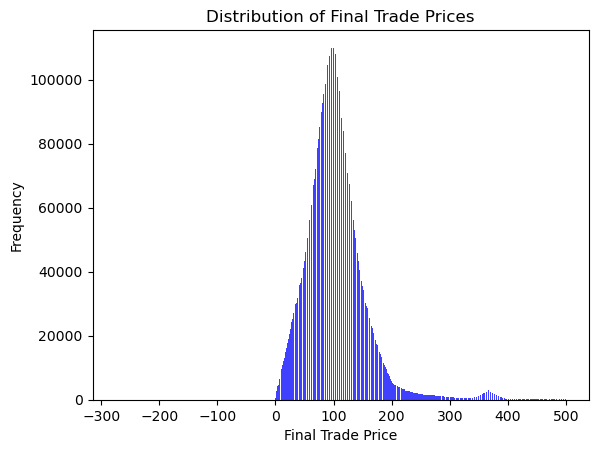

In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(actual_values, bins=1000, alpha=0.75, color='blue')
plt.title('Distribution of Final Trade Prices')
plt.xlabel('Final Trade Price')
plt.ylabel('Frequency')
plt.show()

In [61]:
model_path = 'C:/Users/camer/Documents/Masters Thesis/Deep-Learning-Trader-BFBSE/Neural_network_models/1secbatch_model_v8_MINMAX.keras'

model = tf.keras.models.load_model(model_path)

In [108]:
X = data.drop(columns=['time_of_trade', 'final_trade_price']).values

X_scaled = input_scaler.transform(X)
X_scaled = X_scaled.reshape((-1, 1, X_scaled.shape[1]))

predictions = model.predict(X_scaled)

45182/45182 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step


In [109]:
predictions

array([[104.411606],
       [ 90.82103 ],
       [ 99.731766],
       ...,
       [101.756485],
       [ 97.838455],
       [ 96.82695 ]], dtype=float32)

In [110]:
predictions = predictions.reshape(-1, 1)

unscaled_predictions = output_scaler.inverse_transform(predictions).flatten()

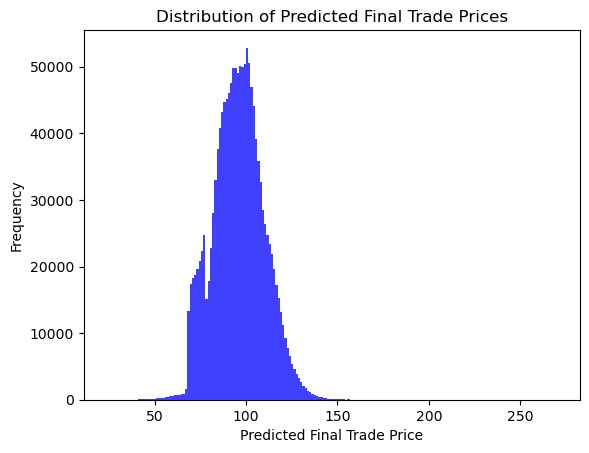

In [103]:
plt.hist(predictions, bins=200, alpha=0.75, color='blue')
plt.title('Distribution of Predicted Final Trade Prices')
plt.xlabel('Predicted Final Trade Price')
plt.ylabel('Frequency')
plt.show()

In [95]:
data['unscaled_predicted_final_trade_price_minmax'] = predictions

data.head(20)

,time_of_publish,bid_ask_spread,midprice,microprice,best_bid,best_ask,prev_batch_price,prev_batch_trade_qty,time_of_trade,final_trade_price,unscaled_predicted_final_trade_price_minmax
0,22.932587,87,43.5,0.000000,0,87,0.0,0,28.462967,95.0,77.764740
1,28.462967,32,69.0,61.000000,53,85,95.0,1,34.534836,91.5,76.644806
2,35.774231,13,94.5,93.909091,88,101,0.0,0,40.063568,115.5,95.479080
3,43.065857,22,113.0,114.100000,102,124,0.0,0,47.097290,100.5,102.727402
4,54.140076,31,108.5,110.222222,93,124,0.0,0,55.417786,124.0,98.526817
5,60.061020,8,97.0,97.173913,93,101,0.0,0,61.280914,101.5,97.440262
6,68.591766,24,100.0,100.000000,88,112,0.0,0,69.806992,111.0,95.978439
7,86.818497,23,98.5,96.200000,87,110,0.0,0,88.043198,110.0,95.956047
8,89.257187,24,100.0,99.142857,88,112,0.0,0,90.471176,117.0,96.178802
9,90.471176,29,102.5,101.809524,88,117,117.0,1,91.714005,88.0,104.737106


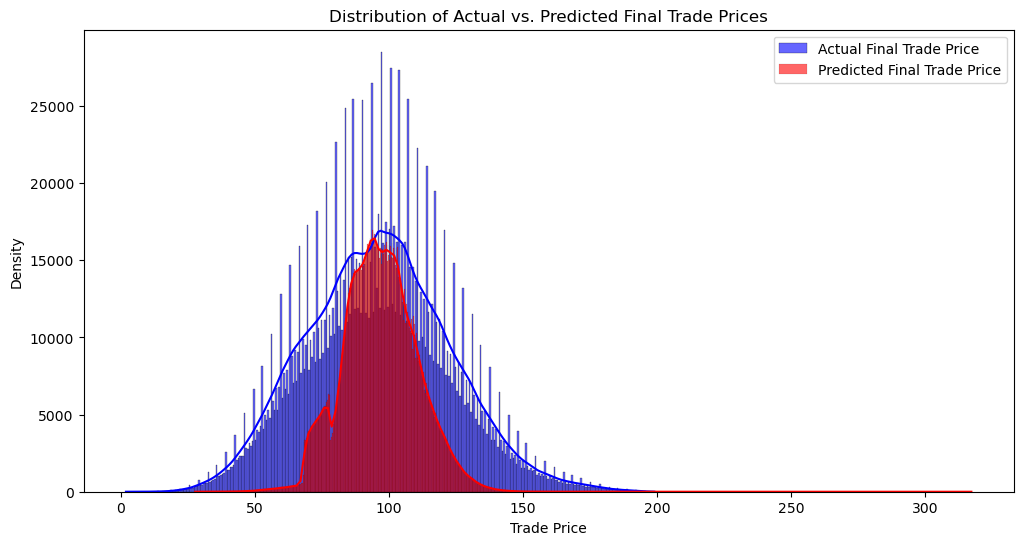

In [87]:
plt.figure(figsize=(12, 6))

sns.histplot(data['final_trade_price'], color='blue', label='Actual Final Trade Price', kde=True, alpha=0.6)

sns.histplot(data['unscaled_predicted_final_trade_price_minmax'], color='red', label='Predicted Final Trade Price', kde=True, alpha=0.6)

plt.title('Distribution of Actual vs. Predicted Final Trade Prices')
plt.xlabel('Trade Price')
plt.ylabel('Density')
plt.legend()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

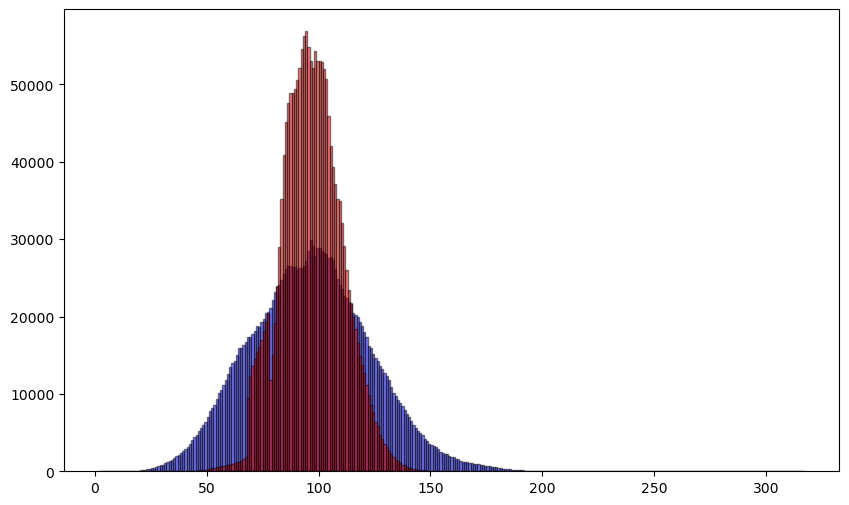

In [88]:
bin_range = range(int(min(actual_values.min(), predictions.min())), 
                  int(max(actual_values.max(), predictions.max())) + 1)


plt.figure(figsize=(10, 6))
plt.hist(actual_values, bins=bin_range, alpha=0.5, label='Actual Final Trade Price', color='blue', edgecolor='black')
plt.hist(predictions, bins=bin_range, alpha=0.5, label='Predicted Final Trade Price', color='red', edgecolor='black')

actual_values.plot(kind='kde', label='Actual Final Trade Price Density', color='blue', linestyle='--')
predictions.plot(kind='kde', label='Predicted Final Trade Price Density', color='red', linestyle='--')

plt.title('Distribution of Actual vs. Predicted Final Trade Prices')
plt.xlabel('Trade Price')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model = Sequential()
model.add(InputLayer(shape=(1, train_generator[0][0].shape[2]), dtype=tf.float16))
model.add(LSTM(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))


# adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss='mean_squared_error')

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Neural_network_models/equil_pred_model/epoch_{epoch:02d}.keras',
    save_freq='epoch',
    save_best_only=False,
    verbose=1
)

history = model.fit(train_generator, epochs=10, validation_data=test_generator, verbose=1)

Epoch 1/10


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


109661/361817 ━━━━━━━━━━━━━━━━━━━━ 28:28 7ms/step - loss: 0.5302

In [8]:
model.save('Neural_network_models/1secbatch_model_v8_current_best.keras')
joblib.dump(history.history, 'training_history_equil_pred_v8.pkl')

['training_history_equil_pred_v7.pkl']

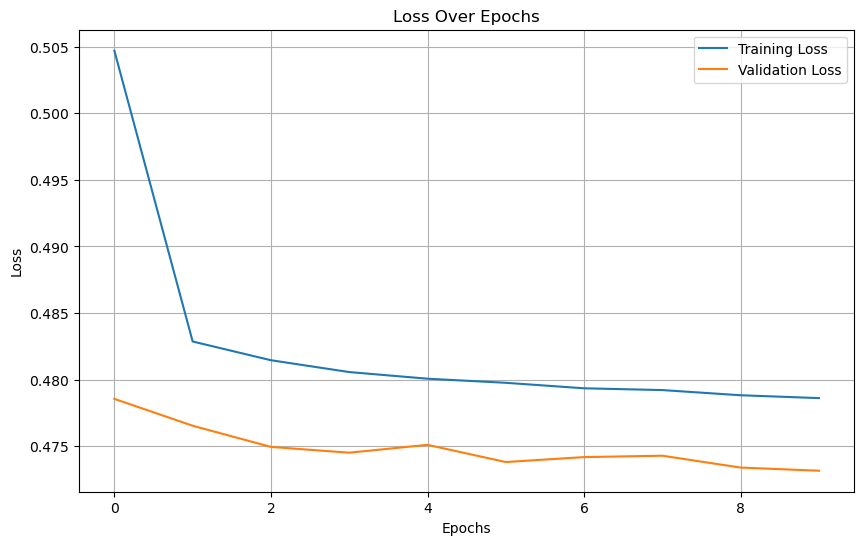

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## --------------- Old code below ----------------

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, training_files, batch_size=1024, scaler=None, shuffle=False):
        self.training_files = training_files
        self.batch_size = batch_size
        self.scaler = scaler
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.training_files))
        self.current_file = None
        self.current_file_idx = 0
        self.data_iterator = None
        self.on_epoch_end()

    def __len__(self):
        total_rows = sum([pd.read_csv(file, usecols=[0]).shape[0] for file in self.training_files])
        print(total_rows)
        return total_rows // self.batch_size

    def __getitem__(self, index):
        if self.data_iterator is None or self.current_file is None or not self.has_next_chunk():
            self.current_file = self.training_files[self.current_file_idx]
            self.data_iterator = pd.read_csv(self.current_file, chunksize=self.batch_size)
            self.current_file_idx = (self.current_file_idx + 1) % len(self.training_files)

        chunk = next(self.data_iterator)
        X_batch = chunk.drop(columns=['time_of_trade', 'final_trade_price']).values
        y_batch = chunk['final_trade_price'].values

        if self.scaler:
            X_batch = self.scaler.transform(X_batch)

        X_batch = X_batch.reshape((-1, 1, X_batch.shape[1]))

        return X_batch.astype(np.float16), y_batch
    
    def on_epoch_end(self):
        self.current_file_idx = 0
        self.indexes = np.arange(len(self.training_files))
        if self.shuffle:
            np.random.shuffle(self.indexes)
        self.current_file = None
        self.data_iterator = None


    def has_next_chunk(self):
        try:
            _ = next(self.data_iterator)
            self.data_iterator = pd.read_csv(self.current_file, chunksize=self.batch_size)
            return True
        except StopIteration:
            return False


Prepping the training data for input - No longer in use

In [4]:
X = training_data.drop(columns=['final_trade_price', 'time_of_trade'])
y = training_data['final_trade_price']

X = X.values
y = y.values

X = X.reshape((X.shape[0], 1, X.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_2d = X_train.reshape((X_train.shape[0], X_train.shape[2]))
X_test_2d = X_test.reshape((X_test.shape[0], X_test.shape[2]))

X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

scaler_filename = 'scaler.joblib'
joblib.dump(scaler, scaler_filename)

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

X_train_scaled = X_train_scaled.astype(np.float16)
X_test_scaled = X_test_scaled.astype(np.float16)

Building the model

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), dtype=tf.float16))
model.add(LSTM(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train_scaled, y_train, epochs=20, validation_split=0.2, verbose=1)
test_loss = model.evaluate(X_test_scaled, y_test, verbose=1)

Save model

In [ ]:
model.save('Neural_network_models/1secbatch_model_v6_current_best.keras')

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()